# Aplicação de Análise de Séries Temporais em Python

Neste notebook apresentamos conceitos de séries temporais usando um caso prático de análise de dados reais. A análise descrita usa dados sobre a pandemia de Covid-19 em algumas das maiores cidades brasileiras, incluindo mobilidade, políticas públicas e casos de Covid. Os dados foram obtidos das seguintes fontes:

- Mobilidade: [Google Mobility Reports](https://www.google.com/covid19/mobility/)

- Políticas públicas: [Brazilian Sub-National Covid-19 Policy Responses](https://github.com/OxCGRT/Brazil-covid-policy)

- Casos e mortes: [Brasil.io](https://brasil.io/)


In [1]:
# Importação de pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns; sns.set()
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import grangercausalitytests

## Lendo dados de um arquivo e filtrando dados de interesse

Os dados coletados foram agregados em um arquivo CSV, exibido abaixo e disponibilizado no reposítório deste tutorial.

In [2]:
# lê o arquivo CSV
df = pd.read_csv('../data/covid_politicas_mobilidade.csv', parse_dates=['Date'])
# mostra o conteúdo do DataFrame
df.head(3)

,State,City,Date,StringencyIndex,city_ibge_code,new_confirmed,new_deaths,confirmed,deaths,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline,avg_mobility
0,para,ananindeua,2020-03-25,80.56,1500800,2,0,6,0,-51.0,-17.0,-59.0,-70.0,-40.0,17.0,-47.4
1,para,ananindeua,2020-03-26,80.56,1500800,2,0,8,0,-50.0,-14.0,-54.0,-69.0,-39.0,17.0,-45.2
2,para,ananindeua,2020-03-27,83.33,1500800,0,0,10,0,-51.0,-11.0,-58.0,-71.0,-36.0,18.0,-45.4


Vamos focar nos dados da cidade de São Paulo no primeiro ano da pandemia de Covid-19. As colunas usadas são a de casos de covid diários, nível de restrições de políticas públicas (StringencyIndex) e média de mobilidade que integra diversos indicadores de mobilidade do Google.

In [3]:
df_sp = df.query("City == 'sao paulo' and Date > '2020-04-01' and Date < '2021-04-02'")

df_sp = df_sp.set_index('Date')
df_sp = df_sp[['new_confirmed', 'StringencyIndex', 'avg_mobility']]
df_sp.columns = ['covid_cases', 'StringencyIndex', 'avg_mobility']

df_sp.head(3)

,covid_cases,StringencyIndex,avg_mobility
Date,,,
2020-04-02,397,81.48,-52.6
2020-04-03,387,81.48,-52.0
2020-04-04,294,81.48,-48.2


## Análises iniciais

Vamos focar inicialmente nos dados de casos de Covid. Abaixo está o gráfico mostrando a série temporal dos dados. É possível ver a tendência das ondas da epidemia bem como padrões repetitivos regulares (sazonalidade).

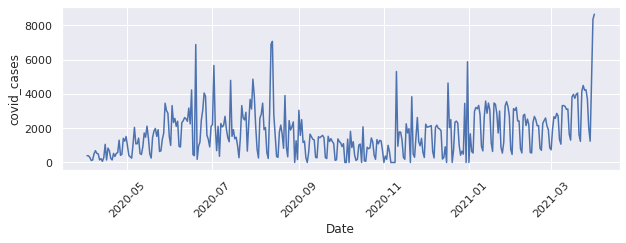

In [4]:
plt.rcParams.update({'figure.figsize': (10,3)})
sns.lineplot(x="Date", y="covid_cases",  data=df_sp)

plt.xticks(rotation=45)
plt.show()

Para verificar as tendências de sazonalidade, podemos aplicar a autocorrelação na série temporal, que calcula a correlação da série original com a série deslocada para diversos números de deslocamento. Abaixo calculamos a autocorrelação para 40 deslocamentos. As maiores correlações aparecem depois de 7 dias de deslocamento, o que indica que há uma sazonalidade semanal nos dados. Isto acontece porque poucos registros de casos de covid são feitos nos fins de semana.

O método de autocorrelação parcial indica a mesma sazonalidade. Este método usa um modelo de regressão linear para eliminar as dependências entre deslocamentos anteriores da série. Em ambos os gráficos a área sombreada indica a região fora da significância estatística, indicando quais das as correlações encontradas não são confiáveis.

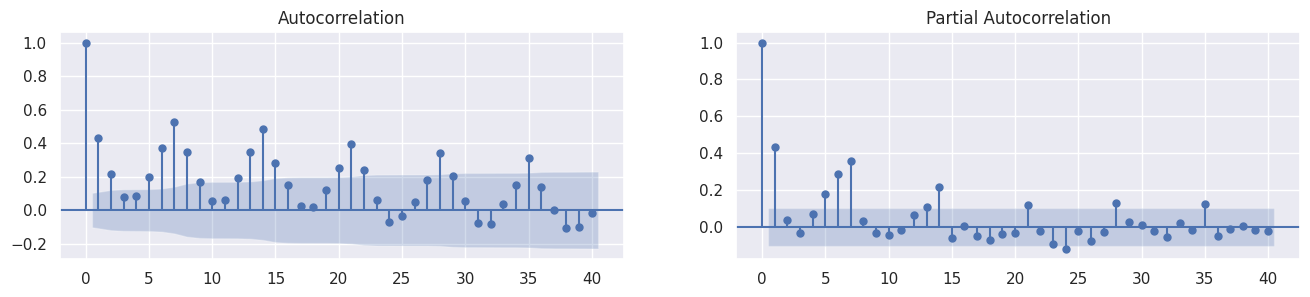

In [5]:
# source: https://www.machinelearningplus.com/time-series/time-series-analysis-python/

fig, axes = plt.subplots(1,2,figsize=(16,3), dpi= 100)
plot_acf(df_sp.covid_cases.tolist(), lags=40, ax=axes[0])
plot_pacf(df_sp.covid_cases.tolist(), lags=40, ax=axes[1])

plt.show()

## Analisando a tendência

Uma forma forma de isolar as variações sazonais para dar ênfase às tendências de longo prazo é pela aplicação da média móvel. No exemplo abaixo aplicamos a média móvel em uma janela de 7 dias, que é a sazonalidade principal identificada no passo anterior.

In [6]:
df_sp['covid_cases_rolling_avg'] = df_sp['covid_cases'].rolling(7, center=True).mean()

df_sp.head(10)

,covid_cases,StringencyIndex,avg_mobility,covid_cases_rolling_avg
Date,,,,
2020-04-02,397,81.48,-52.6,NaN
2020-04-03,387,81.48,-52.0,NaN
2020-04-04,294,81.48,-48.2,NaN
2020-04-05,116,81.48,-49.8,361.285714
2020-04-06,142,81.48,-50.8,380.285714
2020-04-07,504,81.48,-51.4,397.142857
2020-04-08,689,81.48,-49.0,376.428571
2020-04-09,530,81.48,-41.4,391.428571
2020-04-10,505,81.48,-65.0,380.571429


Podemos ver no gráfico abaixo como as tendências dos casos agora são menos afetadas pelas variações sazonais.

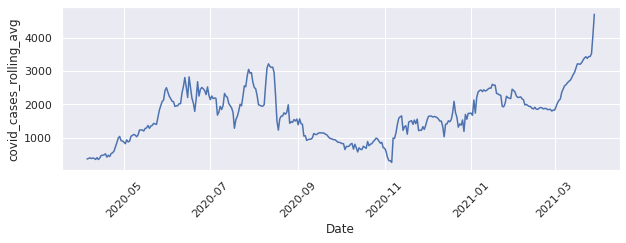

In [7]:
sns.lineplot(x="Date", y="covid_cases_rolling_avg",  data=df_sp)
plt.xticks(rotation=45)
plt.show()

Em análise de séries temporais, é comum aplicar a média móvel múltiplas vezes, em um processo chamado weighted moving average, que gera séries mais suavizadas. Abaixo aplicamos uma média móvel de 5 dias.

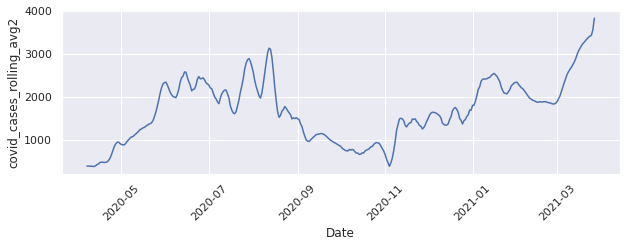

In [8]:
df_sp['covid_cases_rolling_avg2'] = df_sp['covid_cases_rolling_avg'].rolling(5, center=True).mean()

df_sp = df_sp.dropna(how='any')

sns.lineplot(x="Date", y="covid_cases_rolling_avg2",  data=df_sp)
plt.xticks(rotation=45)
plt.show()


Vamos agora usar esta média móvel com peso (5xf(7)) como a tendência para os casos. Para retirar a tendência da nossa série original, basta subtraí-la pela tendência encontrada.

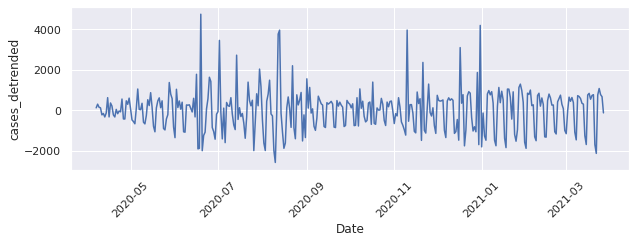

In [9]:
df_sp['cases_trend'] = df_sp['covid_cases_rolling_avg2']

df_sp['cases_detrended'] = df_sp['covid_cases'] - df_sp['cases_trend']

sns.lineplot(x="Date", y="cases_detrended",  data=df_sp)
plt.xticks(rotation=45)
plt.show()

## Analisando a sazonalidade



Para entender melhor a sazonalidade dos dados, podemos agrupar os dados por dia da semana. Os boxplots abaixo mostram a tendência de termos menos dados nos fins de semana.

In [10]:
df_sp['day'] = df_sp.index.day_of_week

df_sp.head()

,covid_cases,StringencyIndex,avg_mobility,covid_cases_rolling_avg,covid_cases_rolling_avg2,cases_trend,cases_detrended,day
Date,,,,,,,,
2020-04-07,504,81.48,-51.4,397.142857,381.314286,381.314286,122.685714,1
2020-04-08,689,81.48,-49.0,376.428571,385.171429,385.171429,303.828571,2
2020-04-09,530,81.48,-41.4,391.428571,379.028571,379.028571,150.971429,3
2020-04-10,505,81.48,-65.0,380.571429,380.085714,380.085714,124.914286,4
2020-04-11,149,81.48,-48.2,349.571429,374.257143,374.257143,-225.257143,5


<AxesSubplot:xlabel='day', ylabel='covid_cases'>

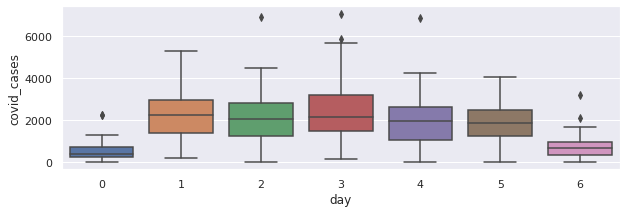

In [11]:
sns.boxplot(x='day', y='covid_cases', data=df_sp)

Uma forma de identificar este componente de sazonalidade é usar as médias dos valores por dia da semana. O gráfico abaixo mostra este componente de sazonalidade isolado.

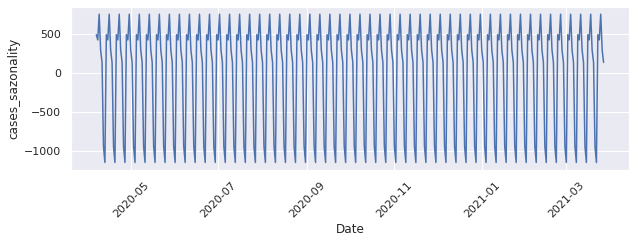

In [12]:
df_sp['cases_sazonality'] = df_sp.groupby('day')['cases_detrended'].transform('mean')

sns.lineplot(x="Date", y="cases_sazonality",  data=df_sp)
plt.xticks(rotation=45)
plt.show()

## Resíduo

Em análise de séries temporais, o resíduo costuma ser toda a variação que não é explicada pela tendência e pela sazonalidade. Para identificar os resíduos, subtraímos a tendência e a sazonalidade dos dados originais. O gráfico abaixo mostra os resíduos identificados. Podemos ver que os resíduos têm uma distribuição relativamente bem comportada, com alguns pontos claros de outlier.

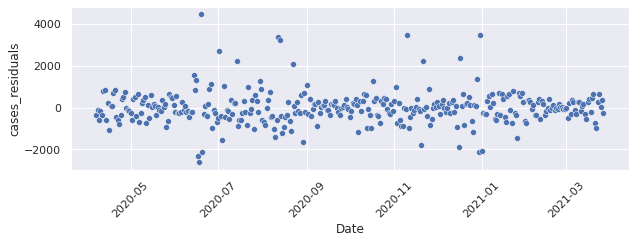

In [13]:
df_sp['cases_residuals'] = df_sp['covid_cases'] - df_sp['cases_trend'] - df_sp['cases_sazonality']

sns.scatterplot(x="Date", y="cases_residuals",  data=df_sp)
plt.xticks(rotation=45)
plt.show()

## Decomposição de Séries usando Statsmodels

O procedimento de decomposição demonstrado acima pode ser automatizado usando o Statsmodels. O código abaixo obtém resultados parecidos usando a biblioteca. A decomposição usada é chamada de decomposição aditiva (porque poderíamos recompor a série original somandos as séries decompostas). Outra forma de decomposição é a multiplicativa, que deve ser usada quando há uma tendência de aumento na amplitude da sazonalidade ao longo do tempo.

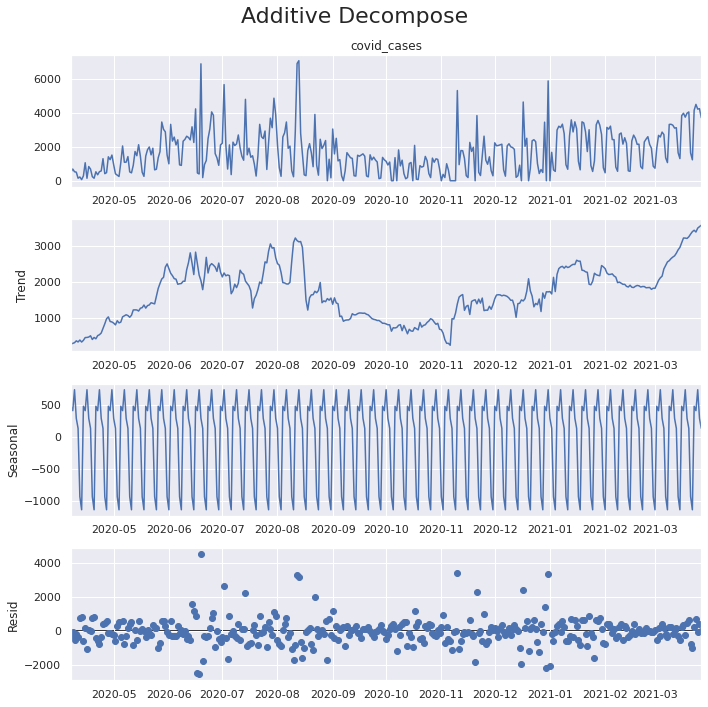

In [14]:
df_sp = df_sp.dropna(how='any')

# Additive Decomposition
result_add = seasonal_decompose(df_sp['covid_cases'], model='additive', extrapolate_trend='freq')

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})

result_add.plot().suptitle('Additive Decompose', fontsize=22)

plt.tight_layout()
plt.show()

## Série estacionária

Muitos modelos que trabalham com séries temporais exigem que as séries sejam estacionárias. Séries estacionárias são as que não apresentam tendências ao longo do tempo. Para testar se uma série é estacionária, podemos usar o teste Augmented Dickey-Fuller (ADF). Abaixo aplicamos o teste para as séries originais de casos e também para a série sem a tendência. O resultado do teste é um p-value que indica nossa confiança da série ser estacionária. Valores baixos, em geral mores que 0.05, indicam uma série estacionária. No nosso caso, apenas a série sem a tendência é estacionária.

In [15]:
#Run ADF test
adf_result = adfuller(df_sp['covid_cases'], autolag='AIC')
print('p-val of the ADF test on covid_cases:', adf_result[1])

adf_result = adfuller(df_sp['cases_detrended'], autolag='AIC')
print('p-val of the ADF test on cases_detrended:', adf_result[1])

p-val of the ADF test on covid_cases: 0.7309252120275667
p-val of the ADF test on cases_detrended: 5.303398441056912e-15


Uma forma que pode ser usada para tentar deixar uma série estacionária é a de diferenciação. Nela, apenas subtraímos o valor atual da série pelo valor anterior. Este processo pode ser aplicado mais de uma vez caso necessário. Abaixo aplicamos a diferenciação uma e duas vezes. O teste ADF mostra que a primeira diferenciação já é suficiente.

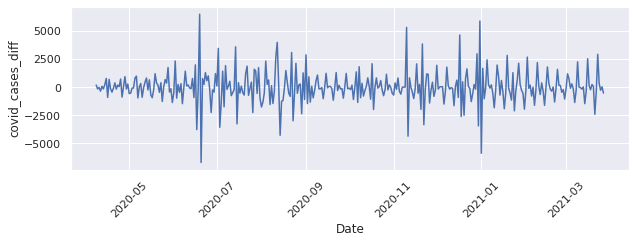

In [16]:
df_sp['covid_cases_diff'] = df_sp['covid_cases'].diff(1)

df_sp = df_sp.dropna(how='any')
plt.rcParams.update({'figure.figsize': (10,3)})
sns.lineplot(x="Date", y="covid_cases_diff",  data=df_sp)
plt.xticks(rotation=45)
plt.show()

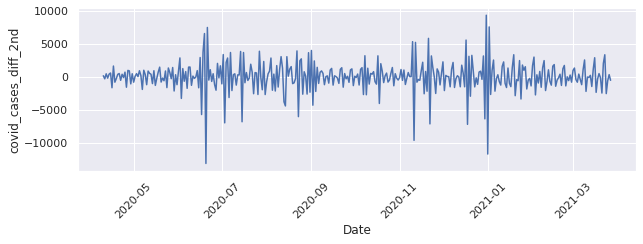

In [17]:
df_sp['covid_cases_diff_2nd'] = df_sp['covid_cases'].diff(1).diff(1)

df_sp = df_sp.dropna(how='any')
plt.rcParams.update({'figure.figsize': (10,3)})
sns.lineplot(x="Date", y="covid_cases_diff_2nd",  data=df_sp)
plt.xticks(rotation=45)
plt.show()

In [18]:
#Run ADF test
adf_result = adfuller(df_sp['covid_cases_diff'], autolag='AIC')
print('p-val of the ADF test on covid_cases_diff:', adf_result[1])

adf_result = adfuller(df_sp['covid_cases_diff_2nd'], autolag='AIC')
print('p-val of the ADF test on covid_cases_diff_2nd:', adf_result[1])

p-val of the ADF test on covid_cases_diff: 7.983394869303971e-19
p-val of the ADF test on covid_cases_diff_2nd: 2.4684970056256305e-19
